In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
FACE_CLASSIFIER = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
EYE_CLASSIFIER = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [4]:
# helper functions
detector_params = cv2.SimpleBlobDetector_Params()
detector_params.filterByArea = True
detector_params.maxArea = 1500
detector = cv2.SimpleBlobDetector_create(detector_params)

def detect_eyes(img, cascade):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = cascade.detectMultiScale(gray_frame, 1.3, 5)  # detect eyes
    width = np.size(img, 1)  # get face frame width
    height = np.size(img, 0)  # get face frame height
    left_eye = None
    right_eye = None
    for (x, y, w, h) in eyes:
        if y > height / 2:
            pass
        eyecenter = x + w / 2  # get the eye center
        if eyecenter < width * 0.5:
            left_eye = img[y:y + h, x:x + w]
        else:
            right_eye = img[y:y + h, x:x + w]
    return left_eye, right_eye

def cut_eyebrows(img):
    height, width = img.shape[:2]
    eyebrow_h = int(height / 4)
    img = img[eyebrow_h:height, 0:width]  # cut eyebrows out (15 px)

    return img


def blob_process(img, threshold, detector):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
    
    img = cv2.erode(img, None, iterations=2)
    img = cv2.dilate(img, None, iterations=4)
    img = cv2.medianBlur(img, 5)
    keypoints = detector.detect(img)
    print(keypoints)
    return keypoints

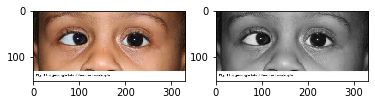

In [5]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(gray,cmap='gray')

plt.show()

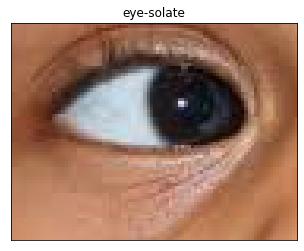

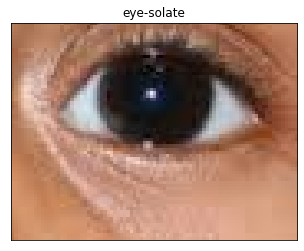

In [6]:
eyes = detect_eyes(img, EYE_CLASSIFIER)

for eye in eyes:
    if eye is not None:
        eye = cut_eyebrows(eye)
        plt.imshow(eye)
        plt.title('eye-solate')
        plt.xticks([]), plt.yticks([])
        plt.show()

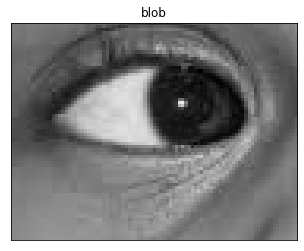

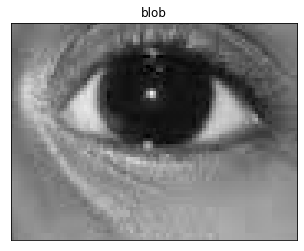

In [7]:
eyes = detect_eyes(img, EYE_CLASSIFIER)
threshold = 60
for eye in eyes:
    if eye is not None:
        eye = cut_eyebrows(eye)
        eye = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
        k = detector.detect(eye)
        im = cv2.drawKeypoints(eye,k,np.array([]),(0,0,255),cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        plt.imshow(im)
        plt.title('blob')
        plt.xticks([]), plt.yticks([])
        plt.show()

In [8]:
def blob_process3(img, threshold, detector):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
    
    img = cv2.erode(img, None, iterations=2)
    img = cv2.dilate(img, None, iterations=4)
    img = cv2.medianBlur(img, 5)
    keypoints = detector.detect(img)
    print(keypoints)
#     for k in range(len(keypoints)):
#         x = keypoints[k].pt[0]
#         y = keypoints[k].pt[1]
#         s = keypoints[k].size
        
#         print(x,y,s)
#     plt.plot(x,y,color='red',marker='o')
    plt.show()
        
    return keypoints

[<KeyPoint 0x119d695a0>]


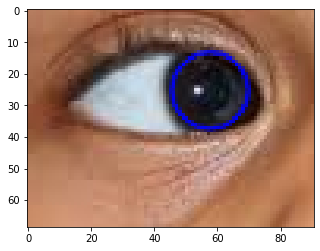

[<KeyPoint 0x119d69ab0>]


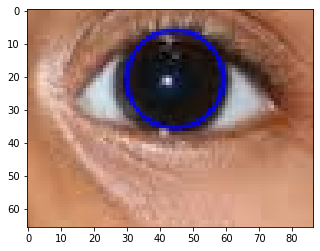

In [9]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
threshold = 60
for eye in eyes:
    eye = cut_eyebrows(eye)
    kp = blob_process3(eye, threshold, detector)
    eye = cv2.drawKeypoints(eye, kp, eye, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.imshow(eye)
    plt.show()

BEST ONE SO FAR

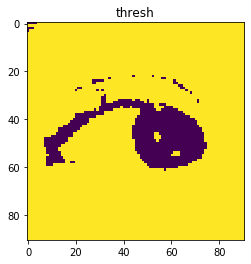

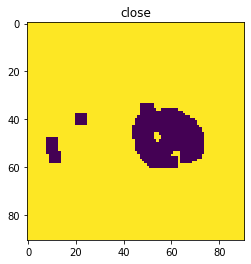

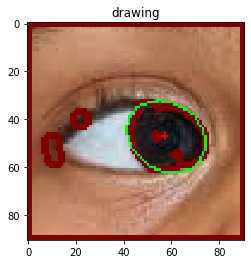

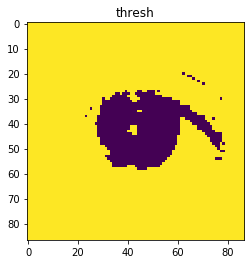

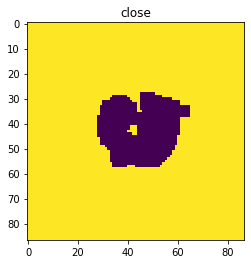

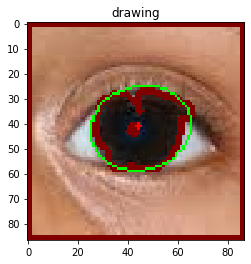

In [50]:
import math

img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# threshold = 20
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
eyes = detect_eyes(img, EYE_CLASSIFIER)

for eye in eyes:
    if eye is not None:
        img = eye
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 60, 255, 0) #CV_THRESH_BINARY
        plt.imshow(thresh)
        plt.title('thresh')
        plt.show()

        c = cv2.erode(cv2.dilate(thresh, kernel,iterations=1),kernel,iterations=1)
        plt.imshow(c)
        plt.title('close')
        plt.show()

        contours, hierarchy = cv2.findContours(c, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        drawing = np.copy(img)
#         cv2.drawContours(drawing, contours,-1,(128,40,40),2)

        for contour in contours:
        
            cv2.drawContours(drawing, contour,-1,(128,0,0),2)

            contour = cv2.convexHull(contour)
            area = cv2.contourArea(contour)
            if area < 250:
                continue
                
            circumference = cv2.arcLength(contour,True)
            circularity = circumference ** 2 / (4*math.pi*area)
            
            bb = cv2.boundingRect(contour)
            extend = area / (bb[2] * bb[3])

            if extend > 0.8:
                continue
            m = cv2.moments(contour)
            if m['m00'] != 0:
                center = (int(m['m10'] / m['m00']), int(m['m01'] / m['m00']))
                cv2.circle(drawing, center, 1, (255, 0, 0), -1)

            try:
                ellipse = cv2.fitEllipse(contour)
                cv2.ellipse(drawing, box=ellipse, color=(0, 255, 0))
            except:
                pass
        
        plt.imshow(drawing)
        plt.title('drawing')
        plt.show()
        

        


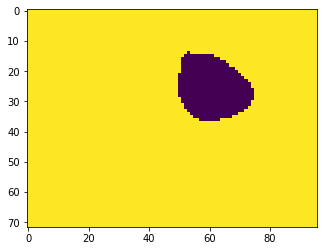

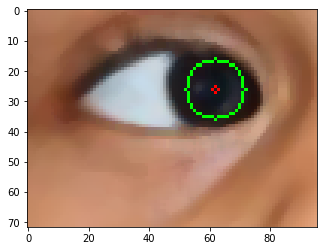

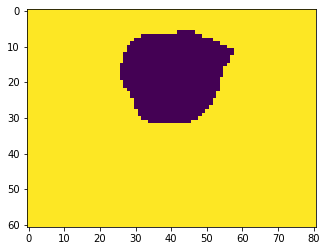

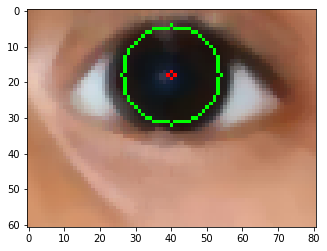

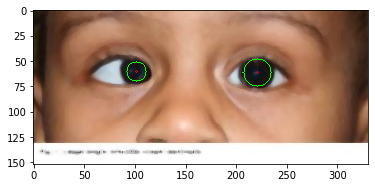

In [44]:
img = cv2.imread('strabismus.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.medianBlur(img,5)
eyes = detect_eyes(img, EYE_CLASSIFIER)

for eye in eyes:
    if eye is not None:
        eye = cut_eyebrows(eye)
        gray = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray,threshold, 255, cv2.THRESH_BINARY)
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=4)
        thresh = cv2.medianBlur(thresh, 5)
        
        circles = cv2.HoughCircles(thresh,cv2.HOUGH_GRADIENT,1,20,
                          param1=30,param2=10,minRadius=0,maxRadius=0)
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            # outer circle
            cv2.circle(eye,(i[0],i[1]),i[2],(0,255,0),1)
            # center
            cv2.circle(eye,(i[0],i[1]),1,(255,0,0),1)
        
        
        plt.imshow(thresh)
        plt.show()
        plt.imshow(eye)
        plt.show()

plt.imshow(img)
plt.show()